In [1]:

import astropy.units as u
import numpy as np
import gala.potential as gp
import gala.dynamics as gd
from gala.dynamics import mockstream as ms
from gala.units import galactic
from astropy.coordinates import SkyCoord, Distance

import matplotlib.pyplot as plt

from tqdm import tqdm
from astropy.constants import G
from gala.units import galactic
import gala.coordinates as gc
import  h5py
import imageio
import seaborn as sns
import matplotlib as mpl
import matplotlib.animation as animation
import astropy.coordinates as astro_coord
import glob
import pandas as pd
sns.set_style("dark")
mpl.rc('xtick', labelsize=16) 
mpl.rc('ytick', labelsize=16) 
font = {'axes.titlesize'      : 'large',   # fontsize of the axes title
        'axes.labelsize'      : 'large', # fontsize of the x any y labels
        'size'   : 20}
import astropy.units as u
from astropy.io import ascii
import itertools
from scipy import stats
#paths

#paths
path_plot = '/users/caganze/research/stellarstreams/figures/paper/'
path_data = '/users/caganze/research/stellarstreams/data/rotating/'
isochrone_path='/users/caganze/research/stellarstreams/data/isochrones/'


from matplotlib.gridspec import GridSpec
%matplotlib inline
#%matplotlib notebook

In [2]:
#function definitions
def evolve_orbits_only(st_coord, pert_coord, pert_pot, time_dict):
    #evolve stream and nbody for a short period without releasing any stars
    w0 = gd.combine((st_coord, pert_coord,))
    particle_pot = [list([pert_pot]) + [gp.NullPotential(units=pert_pot.units)] * st_coord.shape[0]][0]
    
    nbody = gd.DirectNBody(w0, particle_pot, external_potential=MWPOT, save_all=False)

    return  nbody.integrate_orbit(**time_dict)



### These are the important definitions. The lines above are just to show how the stuff used in here are originally defined
def get_cyl_rotation(site_at_impact_w0): #borrowed from Adrian Price-Whelan's streampunch github repo
    L = site_at_impact_w0.angular_momentum()
    v = site_at_impact_w0.v_xyz

    new_z = v / np.linalg.norm(v, axis=0)
    new_x = L / np.linalg.norm(L, axis=0)
    new_y = -np.cross(new_x, new_z)
    R = np.stack((new_x, new_y, new_z))
    return R


def get_perturber_w0_at_impact(site_at_impact_w0, psi, v_rho, v_z, vpsi):

    # Get the rotation matrix to rotate from Galactocentric to cylindrical
    # impact coordinates at the impact site along the stream
    R = get_cyl_rotation(site_at_impact_w0)

    psi, v_rho, v_z, vpsi =  psi * u.rad, v_rho*u.km/u.s,  v_z * u.km/u.s, vpsi * u.rad/u.s

    # Define the position of the perturber at the time of impact in the
    # cylindrical impact coordinates:
    perturber_pos = astro_coord.CylindricalRepresentation(rho=0*u.kpc, 
                                                    phi=psi,
                                                    z=0*u.kpc) 

    # Define the velocity in the cylindrical impact coordinates:
    #maybe we want this to have the same vz as the stream?
    perturber_vel = astro_coord.CylindricalDifferential(
        d_rho=v_rho,
        d_phi=vpsi,
        d_z=v_z)

    # Transform from the cylindrical impact coordinates to Galactocentric
    perturber_rep = perturber_pos.with_differentials(perturber_vel)
    perturber_rep = perturber_rep.represent_as(
        astro_coord.CartesianRepresentation, astro_coord.CartesianDifferential)
    perturber_rep = perturber_rep.transform(R.T)

    pos = perturber_rep.without_differentials() + site_at_impact_w0.pos
    vel = perturber_rep.differentials['s'] + site_at_impact_w0.vel

    # This should be in Galactocentric Cartesian coordinates now!
    return gd.PhaseSpacePosition(pos, vel)

In [3]:
#now run a stream forward and choose an impact site
NSTEPS= np.int(700*12/8) #control stream's length
file_prefix='simpler_rgc50'

/var/folders/p5/jqfspzln0z965dsfd1pj_5900000gp/T/ipykernel_42564/605324442.py:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  NSTEPS= np.int(700*12/8) #control stream's length


In [4]:
#some global parameters
#galactocentric reference frame
v_sun = astro_coord.CartesianDifferential([11.1, 220 + 24.0, 7.25]*u.km/u.s)
galcen_frame =astro_coord.Galactocentric(galcen_distance=8.*u.kpc,
                                    galcen_v_sun=v_sun)

#present day position of stream        
gd1_w0=gd.PhaseSpacePosition(SkyCoord(x=1*u.kpc, y=1* u.kpc,z=50*u.kpc, \
                                                v_x=150*u.km/u.s, v_y=150*u.km/u.s, v_z=0*u.km/u.s,\
                                                 frame=galcen_frame).cartesian)

#potential of the galaxy
MWPOT = gp.MilkyWayPotential()
H = gp.Hamiltonian(MWPOT)


#stream potential
gd1_mass = 3e4 * u.Msun
gd1_pot = gp.PlummerPotential(m=gd1_mass, b=5*u.pc, units=galactic)
df = ms.FardalStreamDF()

[Text(0.5, 0, 'y (kpc)'), Text(0, 0.5, 'z (kpc)')]

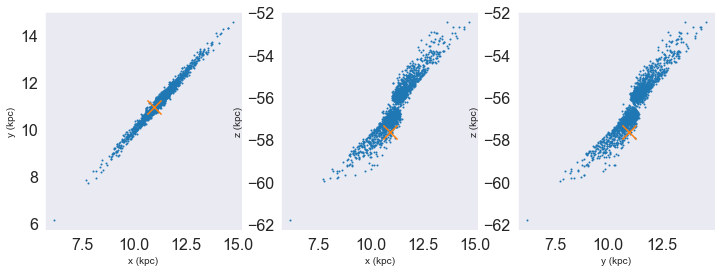

In [5]:


#integrate back to create a stream
gen_gd1 = ms.MockStreamGenerator(df, MWPOT)#, progenitor_potential=gd1_pot)
stream, nbody = gen_gd1.run(gd1_w0, gd1_mass,
                                dt=-1 * u.Myr, n_steps=NSTEPS)


w0_now = gd.PhaseSpacePosition(stream.data, stream.vel)

t_int=NSTEPS

orbit = MWPOT.integrate_orbit(w0_now, dt=-1*u.Myr, n_steps=int(t_int))
old_stream = orbit[-1]

#choose impact position somewhere in the tail
impact_bool1= (((old_stream.pos.x.value-np.mean(old_stream.pos.x.value))**2+
                                    (old_stream.pos.y.value-np.mean(old_stream.pos.y.value))**2+
                                    (old_stream.pos.z.value-np.mean(old_stream.pos.z.value))**2)**0.5) >=1.3

impact_bool0= (((old_stream.pos.x.value-np.mean(old_stream.pos.x.value))**2+
                                    (old_stream.pos.y.value-np.mean(old_stream.pos.y.value))**2+
                                    (old_stream.pos.z.value-np.mean(old_stream.pos.z.value))**2)**0.5) <=1.4
impact_site= np.logical_and(impact_bool1, impact_bool0)



#site_at_impact_w0 = gd.PhaseSpacePosition(pos=np.mean(old_stream.pos), \
#                                          vel=np.mean(old_stream.vel
site_at_impact_w0=gd.PhaseSpacePosition(pos=old_stream.pos[impact_site][0], \
                                          vel=old_stream.vel[impact_site][0])
#visualize
fig, ax=plt.subplots(ncols=3, figsize=(12, 4))
ax[0].scatter(old_stream.pos.x, old_stream.pos.y, s=1)
ax[1].scatter(old_stream.pos.x, old_stream.pos.z, s=1)
ax[-1].scatter(old_stream.pos.y, old_stream.pos.z, s=1)

ax[0].scatter(site_at_impact_w0.pos.x, site_at_impact_w0.pos.y, s=200, marker='x')
ax[1].scatter(site_at_impact_w0.pos.x, site_at_impact_w0.pos.z, s=200, marker='x')
ax[-1].scatter(site_at_impact_w0.pos.y, site_at_impact_w0.pos.z, s=200, marker='x')

ax[0].set(xlabel='x (kpc)', ylabel='y (kpc)')
ax[1].set(xlabel='x (kpc)', ylabel='z (kpc)')
ax[-1].set(xlabel='y (kpc)', ylabel='z (kpc)')
#vxstream, vystream, vzstream not defined in this file but its just the velocity of the stream
#jk

In [6]:
#choose the subhalo properties
frac=10.0
vpsi= ((1*u.km/u.s)/(0.01*u.kpc)).to(u.rad/u.s, u.dimensionless_angles()).value
impact_vector=frac*(np.array([-(1/frac)*(np.pi/2), -5, -5, (1/frac)*np.pi/2]))
perturb= get_perturber_w0_at_impact(site_at_impact_w0, *impact_vector)
print (impact_vector)
print (perturb.xyz, perturb.v_xyz)

[ -1.57079633 -50.         -50.           1.57079633]
[ 10.93535954  10.96974379 -57.65108948] kpc [-71.83391889 -72.173198   -97.83222046] km / s


In [ ]:
#run both the pertuber and the subhalo as potential object for a few Myr
forward_time= {'dt':100*u.Myr, 'nsteps': 10, 't1': -100*u.Myr}


mhalo=10**6
rhalo=1005*((mhalo/10**8)**0.5)
#define the potential of the subhalo pummer sphere for now
subhalo_pot=gp.HernquistPotential(mhalo*u.Msun,  rhalo*u.pc, units=galactic)


#some reformatting 
#mean stream position
st_x=gd.PhaseSpacePosition(pos= old_stream.xyz,
                            vel=[old_stream.v_x.value, \
                                 old_stream.v_y.value,\
                                 old_stream.v_z.value]*u.kpc/u.Myr)

halo_x= gd.PhaseSpacePosition(pos= perturb.pos,
                                vel=perturb.vel)

halo_and_stream= evolve_orbits_only(st_x, halo_x, subhalo_pot, forward_time)

In [ ]:
final_stream=halo_and_stream

In [ ]:
fig, ax=plt.subplots(ncols=3, figsize=(12, 4))
ax[0].scatter(final_stream.pos.x, final_stream.pos.y, s=1)
ax[1].scatter(final_stream.pos.x, final_stream.pos.z, s=1)
ax[-1].scatter(final_stream.pos.y,final_stream.pos.z, s=1)

In [ ]:
#save
final_stream_coord=SkyCoord(x=final_stream.x,
                            y=final_stream.y,
                            z=final_stream.z, 
                            v_x=final_stream.v_x,
                            v_y=final_stream.v_y,
                            v_z=final_stream.v_z,
                           frame=galcen_frame)

In [ ]:
#save this 
filename= file_prefix+'_direct_nbody{:.2e}'.format(mhalo)
final_data={'stream': final_stream_coord, 'prog': None}
np.save(path_data+'/{}.npy'.format(filename), final_data)